# Test Rare Event Algorithms on Toy Examples

## 1. Imports

In [1]:
import torch
import math
import stat_reliability_measure.config as config_
from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import stat_reliability_measure.dev.torch_utils as t_u
import scipy.stats as stats
from stat_reliability_measure.dev.amls.amls_config import MLS_SMC_Config
import stat_reliability_measure.dev.utils as utils
import stat_reliability_measure.run_toy_exp as run_toy_exp
from stat_reliability_measure.config import ExpToyConfig
import stat_reliability_measure.dev.smc.smc_pyt as smc_pyt
import stat_reliability_measure.dev.smc.smc_config as smc_config
import stat_reliability_measure.dev.amls.amls_pyt as amls_pyt
import stat_reliability_measure.dev.form.form_pyt as form_pyt
import stat_reliability_measure.dev.amls.amls_config as amls_config 
import stat_reliability_measure.dev.mls.webb_config as webb_config
import stat_reliability_measure.dev.form.form_config as form_config
import stat_reliability_measure.dev.mls.amls_uniform as amls_webb
import stat_reliability_measure.dev.mc.mc_pyt as mc_pyt
import stat_reliability_measure.dev.mc.mc_config as mc_config
import stat_reliability_measure.dev.hmls.hmls_pyt as hmls_pyt
import stat_reliability_measure.dev.hmls.hmls_config as hmls_config
import stat_reliability_measure.dev.torch_arch as t_a
from stat_reliability_measure.dev.utils import range_vars,simple_vars
import pandas as pd
import numpy as np
import os 

## 2. Experiments on Quadratic-Sigmoid score function

Given parameters $a, r_0, dv \in \mathbb{R}_+$, we use the following score function,  
$$ h_{r_0,a,dv}: \mathbb{R}^2\ni x=(x_1,x_2) \mapsto x_1^2+ a x_2^2 + \frac{2(1-a)}{1+e^{-\frac{r_0^2-\|x\|^2}{dv}}}x_2^2 \\ = x_1^2 +\left(a+2(1-a)\sigma\left(\frac{\|x\|^2-r_0^2}{dv}\right)\right)x_2^2 $$
where $\sigma$ is the logistic function, i.e. $\sigma(x)=\frac{1}{1+e^{-x}}$
Notice that at if $\|x\|=r_0$, we have simply $$h(x)=\|x\|^2=r_0^2$$


Using the chain rule we see that,
$$ \nabla_x h(x)  = 2\begin{pmatrix} x_1 \\ ax_2   \end{pmatrix} + 2(1-a)\left(x_2^2\frac{2}{dv}\sigma'(\frac{\|x\|^2-r_0^2}{dv}) \begin{pmatrix} x_1 \\ x_2  \end{pmatrix}+2\sigma\left(\frac{\|x\|^2-r_0^2}{dv}\right) \begin{pmatrix}0 \\ x_2 \end{pmatrix} \right)   $$
Thus if $V$ is the negative part of $h$ (i.e. $V(x)=\max(-h(x),0)$), the gradient associated with this potential function is:
$$ \nabla_x V(x) = -\nabla_x h(x) \mathbb{1}_{h(x)<0} $$

In [3]:
reload(amls_config)
reload(config_)
reload(webb_config)
reload(amls_webb)
reload(amls_pyt)
reload(smc_pyt)
reload(smc_config)
reload(run_toy_exp)
reload(form_config)
reload(t_u)
reload(form_pyt)
reload(mc_config)
reload(mc_pyt)
reload(hmls_config)
reload(hmls_pyt)

<module 'stat_reliability_measure.dev.hmls.hmls_pyt' from '/home/karimtito/repos/stat_reliability_measure/dev/hmls/hmls_pyt.py'>

In [4]:

f = lambda v,r0: v[0]**2 + t_u.sig(v[0]**2+v[1]**2,r0) * v[1]**2
def plot_f(f,r0):
    l = 1.4*r0
    x = torch.linspace(-l, l,1000)
    y = torch.linspace(-l, l,1000)
    xx, yy = torch.meshgrid(x, y)
    zz = f([xx,yy],r0)
    max_level=zz.max()
    min_level=zz.min()
    contour_levels = list(np.linspace(5,max_level*1.1,15))
    contour_levels.append(f(torch.Tensor([r0,0.]),r0).numpy())
    contour_levels.sort()
    contour_levels = np.array(contour_levels)
    plt.figure(figsize=(6,6))
    contours = plt.contour(xx,yy,zz,levels=contour_levels,cmap='viridis')
    plt.clabel(contours, inline=True, fontsize=7)
    plt.axis('scaled')
    plt.colorbar(contours, shrink=0.8, extend='both')
    

Running reliability experiments with quadratic 
Testing score function 'quadratic' with p_target in [0.0001]
with parameters in {'N_range': [10000000], 'batch_size_range': [400000]}
aggregate results csv file not found 
 it will be build at /home/karimtito/repos/stat_reliability_measure/logs/toy_exp/aggr_res.csv
Starting CrudeMC simulation 1/1, with score: quadratic, p_target:0.0001,N: 10000000: batch_size: 400000


100%|██████████| 3/3 [00:00<00:00, 17.44it/s]

mean est:9.950000094249845e-05, std est:1.43527199725213e-06
mean calls:10000000.0
std. re.:144.9733057307991
std. rel. adj.:1449733057.307991
mean rel. error:0.015000018291175365
std rel. error:0.0024494787212461233
stat performance (per 1k calls):2.3100046382751316



/home/karimtito/repos/stat_reliability_measure/run_toy_exp.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agg_res_df = pd.concat([agg_res_df,result_df],ignore_index=True)
/home/karimtito/venvs/deep_l/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


p_fail_mc=9.950000094249845e-05


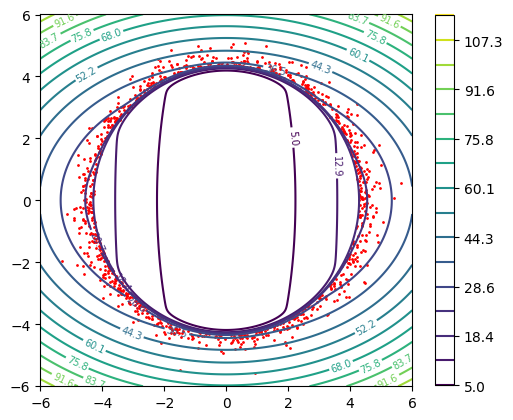

In [5]:
p_fail_mc, dict_out_mc = run_toy_exp.run_toy_exp(method = 'CrudeMC',
            score_name='quadratic',noise_scale=1.,noise_dist='gaussian',dim=2,
            p_target_range=[1e-4], verbose=True, 
            repeat_exp=True,n_rep=3, 
            N_range=[int(1e7)],batch_size_range=[int(4e5)],track_advs=True) 
exp_config,method_config_mc, agg_res_df = dict_out_mc['exp_config'],dict_out_mc['method_config'],dict_out_mc['agg_res_df']
results_df_mc = dict_out_mc['results_df']
X_advs_mc = dict_out_mc['advs_list'][0]
print(f"p_fail_mc={p_fail_mc}")
r0 = exp_config.thresh
plot_f(f,r0)
plt.scatter(X_advs_mc[:,0],X_advs_mc[:,1],c='r',s=1)

In [6]:
p_fail_hmls, dict_out=run_toy_exp.run_toy_exp(score_name='quadratic', method='hmls',p_target=1e-6, dim=2,
                        n_rep=1, verbose=0, track_accept=True,ratio_range=[0.8],track_levels=True,
                          noise_dist='gaussian', noise_scale=1.,
                        alpha=0.25, L_range=[2], only_duplicated=True,track_advs=True,
                      track_X=False,
                         N_range=[1000],T_range=[10],repeat_exp=True,
 )


exp_config,method_config_hmls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_hmls = dict_out['results_df']
# X_hmls=dict_out['X_list'][0]
X_hmls_adv = dict_out['advs_list'][0]
print(f"p_fail_hmls={p_fail_hmls}")
r0 = exp_config.thresh
plot_f(f,r0)
plt.scatter(X_hmls_adv[:,0],X_hmls_adv[:,1],c='r',s=1)

with parameters in {'N_range': [1000], 'T_range': [10], 'ratio_range': [0.8], 'alpha_range': [0.25], 'L_range': [2]}
Starting HMLS simulation 1/1, with score: quadratic, p_target:1e-06,N: 1000: T: 10: ratio: 0.8: alpha: 0.25: L: 2


  0%|          | 0/1 [00:00<?, ?it/s]

../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [1,0,0], thread: [64,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [1,0,0], thread: [65,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [1,0,0], thread: [66,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [1,0,0], thread: [67,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [1,0,0], thread: [68,0,0] Assertion `cumdist[size - 1] > static_cast<scalar_t>(0)` failed.
../aten/src/ATen/native/cuda/MultinomialKernel.cu:112: binarySearchForMultinomial: block: [1,0,

NaN values in lambda_i:
tensor([1.0000e-08, 1.2035e+00, 1.0000e-08, 1.0000e-08, 1.0000e-08, 2.9560e-03,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.1900e+00, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 4.9255e+19, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0767e+00, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        6.0077e-01, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 9.9371e-01,
        1.0000e-08, 1.0000e-08, 4.1454e-01, 1.2516e+00, 1.5985e+00, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.5861e+00, 1.0000e-08, 1.0000e-08, 4.2154e+00, 1.1691e+00, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        3.0816e-

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Running reliability experiments with cosinus 
Testing score function 'cosinus' with p_target in [0.0001]
with parameters in {'N_range': [10000], 'T_range': [10], 'ratio_range': [0.5], 's_range': [1.0]}
Starting MLS_SMC simulation 1/1, with score: cosinus, p_target:0.0001,N: 10000: T: 10: ratio: 0.5: s: 1.0


100%|█████████████████████████████████████████████| 2/2 [00:11<00:00,  5.55s/it]


mean est:0.0, std est:0.0
mean calls:99910000.0
std. re.:0
std. rel. adj.:0.0
mean rel. error:1.0
std rel. error:0.0
stat performance (per 1k calls):0.0
p_fail_mls: 0.0


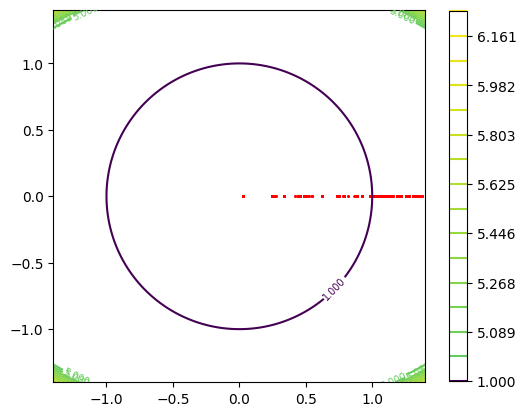

In [27]:
p_fail_mls,dict_out=run_toy_exp.run_toy_exp(score_name='cosinus',p_target=1e-4,
                    method = 'amls_batch',noise_scale=1.,noise_dist='gaussian',dim=2,
                    n_rep=2, update_aggr_res=False, 
                         N_range=[10000],T_range=[10],ratio_range=[0.5,],repeat_exp=False,
                         track_levels=True,track_X=False,track_advs=True,
                        verbose=1,np_seed=0, torch_seed=0,)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
X_amls_adv = dict_out['advs_list'][0]
print(f"p_fail_mls: {p_fail_mls}")
r0 = exp_config.thresh
plot_f(f,r0)
plt.scatter(X_amls_adv[:,0],X_amls_adv[:,1],c='r',s=1)

Running reliability experiments with linear 
Testing score function 'linear' with p_target in [0.0001]
with parameters in {'N_range': [10000], 'T_range': [10], 'ess_alpha_range': [0.9], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with score: linear, p_target:0.0001,N: 10000: T: 10: ess_alpha: 0.9: alpha: 0.2: L: 1


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.68it/s]


mean est:0.00010106158661074005, std est:2.2835027024381444e-06
mean calls:2940000.0
std. re.:223.57812291182273
std. rel. adj.:657319681.3607588
mean rel. error:0.019810858147684463
std rel. error:0.015545577244567295
stat performance (per 1k calls):45.703997099027845
p_fail_rw=0.00010106158661074005


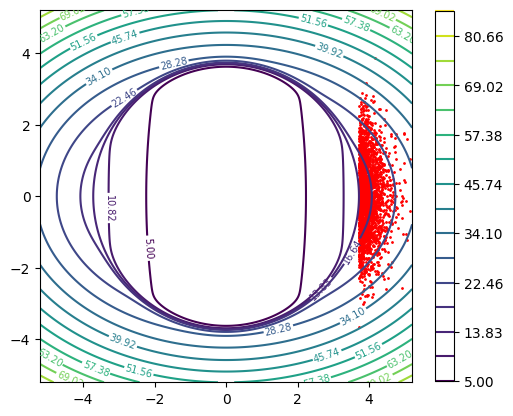

In [31]:
p_fail_rw, dict_out=run_toy_exp.run_toy_exp(score_name='linear', method='mala',p_target=1e-4,
                        n_rep=10, verbose=1, track_accept=True,ess_alpha_range=[0.9],
                        noise_dist='gaussian',  dim=2,gaussian=True,noise_scale=1.,
                        adapt_step=True, only_duplicated=False,
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',min_rate=0.2,
                         N_range=[10000],T_range=[10],repeat_exp=True,track_advs=True
 )
exp_config,method_config_rw, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_rw = dict_out['results_df']
print(f"p_fail_rw={p_fail_rw}")
X_rw_adv = dict_out['advs_list'][0]
r0 = exp_config.thresh
plot_f(f,r0)
plt.scatter(X_rw_adv[:,0],X_rw_adv[:,1],c='r',s=1)

Running reliability experiments with linear 
Testing score function 'linear' with p_target in [0.0001]
with parameters in {'N_range': [10000], 'T_range': [10], 'ess_alpha_range': [0.9], 'alpha_range': [0.2], 'L_range': [1]}
Starting RW_SMC simulation 1/1, with score: linear, p_target:0.0001,N: 10000: T: 10: ess_alpha: 0.9: alpha: 0.2: L: 1


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.55it/s]


mean est:0.00010019804394687526, std est:1.89698631490432e-06
mean calls:820000.0
std. re.:188.94948437111088
std. rel. adj.:154938577.1843109
mean rel. error:0.01511069644475355
std rel. error:0.011638071203482668
stat performance (per 1k calls):9.543218386855788
p_fail_rw=0.00010019804394687526


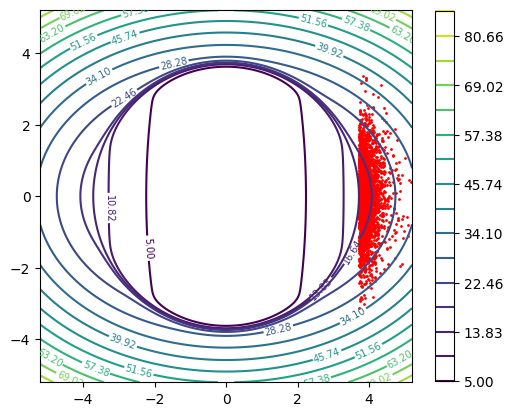

In [32]:
p_fail_rw, dict_out=run_toy_exp.run_toy_exp(score_name='linear', method='rw_smc',p_target=1e-4,
                        n_rep=10, verbose=1, track_accept=True,ess_alpha_range=[0.9],
                        noise_dist='gaussian',  dim=2,gaussian=True,noise_scale=1.,
                        adapt_step=True, only_duplicated=False,
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',min_rate=0.2,
                         N_range=[10000],T_range=[10],repeat_exp=True,track_advs=True
 )
exp_config,method_config_rw, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_rw = dict_out['results_df']
print(f"p_fail_rw={p_fail_rw}")
X_rw_adv = dict_out['advs_list'][0]
r0 = exp_config.thresh
plot_f(f,r0)
plt.scatter(X_rw_adv[:,0],X_rw_adv[:,1],c='r',s=1)

<function build_h_lin.<locals>.h at 0x7fc1d6c5c8b0>
<class 'function'>
with parameters in {'N_range': [10000], 'T_range': [5], 'ess_alpha_range': [0.75], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with score: linear, p_target:0.0001,N: 10000: T: 5: ess_alpha: 0.75: alpha: 0.2: L: 1


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:28<00:00,  2.27it/s]


mean est:9.980802744394168e-05, std est:3.165537248274118e-06
mean calls:1372146.0
std. re.:317.7726261911682
std. rel. adj.:436030437.93770665
mean rel. error:0.02565205434919335
std rel. error:0.018647253441594944
stat performance (per 1k calls):25.586754220870734
p_fail_mala=9.980802744394168e-05


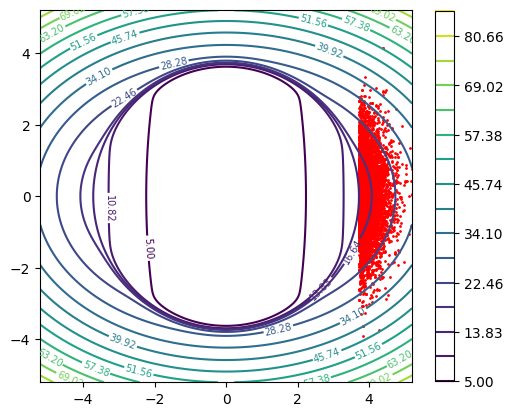

In [36]:
p_fail_mala, dict_out=run_toy_exp.run_toy_exp(score_name='linear', method='mala',p_target=1e-4,
                        n_rep=200, verbose=0, track_accept=False,ess_alpha_range=[0.75],min_rate=0.8,
                        alpha=0.2, L_range=[1], only_duplicated=True,
                         N_range=[10000],T_range=[5],repeat_exp=True,track_advs=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
X_mala_adv= dict_out['advs_list'][0]

r0 = exp_config.thresh
plot_f(f,r0)
print(f"p_fail_mala={p_fail_mala}")
plt.scatter(X_mala_adv[:,0],X_mala_adv[:,1],c='r',s=1)

In [ ]:
p_fail_mala

8.720471669221297e-05

In [ ]:
p_fail_mc, dict_out_mc = run_toy_exp.run_toy_exp(method = 'CrudeMC',
            score_name='quadratic',noise_scale=1.,noise_dist='gaussian',dim=2,
            p_target_range=[1e-6], verbose=True, track_X=True,
            repeat_exp=True,n_rep=30, 
            N_range=[int(1e7)],batch_size_range=[int(4e5)],track_advs=False) 
exp_config,method_config_mc, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mc = dict_out['results_df']
X_mc=dict_out['X_list'][0]
print(f"p_fail_mc={p_fail_mc}")

ValueError: unknown configuration parameter track_X

In [53]:
exp_config.model

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

## 4. Analysis of Experiments

In [65]:
eps=0.18

NameError: name 'eps' is not defined

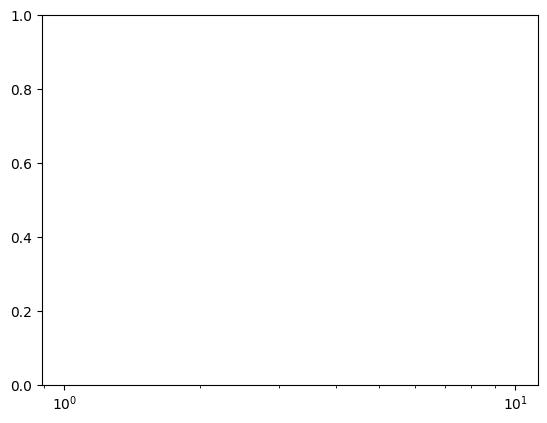

In [21]:
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
mls_webb_df=  utils.get_sel_df(df=agg_res_df,triplets=[('method_name','MALA_SMC','='),])
for T in agg_res_df['T'].unique():
    df = utils.get_sel_df(mls_webb_df,triplets=[('T',T,'='),('epsilon',eps,'=')])
    ax.errorbar(x=df['mean_calls'],y=df['mean_log_est'], yerr=df['std_log_est'],label=f'mean_log, T={T}',)
    ax.legend()

